# Initial infrastructure

In [1]:
import pandas as pd
import numpy as np
import os
import re
from dateutil.relativedelta import relativedelta
from statsmodels.tsa import seasonal
from matplotlib import pyplot as plt
from functools import reduce  # Operação de reduce para cálculo de média de uma lista
from datetime import datetime
%matplotlib inline

#Configurações para exibição de tableas
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


# Nomes das colunas adicionadas ao dataframe
COLUNA_ANOMALIA_ACUMULADA = "anomalia_acumulada"
COLUNA_ANOMALIA_DO_MES = "anomalia_mensal"
COLUNA_MEDIA_MENSAL = "media_mensal"

# Todo mês possui 25 linhas por 38 colunas que dá 950
BLOCO_DE_DADOS_DE_UM_MES = 950
QUANTIDADE_DE_VALORES_DO_ARQUIVO = 573800  # (950 blocos x 604 meses,01/1964 até 04/2014)


class LatitudeColumns:

    def __init__(self):
        self.values = range(29, -21, -2)
        self.positive = 'N'
        self.negative = 'S'

    def get_all_columns(self):
        colum_names = []
        for value in self.values:
            if value > 0:
                colum_name = str(value) + self.positive
            else:
                colum_name = str(value) + self.negative
            colum_names.append(colum_name)
        return colum_names

    def get_single_column(self, desired_value, human_readable=True):
        sub_values = []
        for value in self.values:
            if value != desired_value:
                continue
            sub_values.append(value)
        if human_readable:
            return self.parse_human_readable(sub_values)
        return sub_values

    def get_range(self, init, final, human_readable=True):
        final, init = self.switch(final, init)

        sub_values = []
        if init == final:
            return self.get_single_column(init, human_readable)

        for value in self.values:
            if (value > init) or (value < final):
                continue
            sub_values.append(value)

        if human_readable:
            return self.parse_human_readable(sub_values)

        return sub_values

    def switch(self, final, init):
        if final > init:
            aux = init
            init = final
            final = aux
        return final, init

    def parse_human_readable(self, list):
        colum_names = []
        for value in list:
            if value > 0:
                colum_name = str(value) + self.positive
            else:
                colum_name = str(-value) + self.negative
            colum_names.append(colum_name)
        return colum_names

class LongitudeColumns:

    def __init__(self):
        #From map 60W to 15E(-17 because 'force' go to -15)
        self.values = range(59, -17, -2)
        self.positive = 'W'
        self.negative = 'E'

    def get_all_columns(self):
        colum_names = []
        for value in self.values:
            if value > 0:
                colum_name = str(value) + self.positive
            else:
                colum_name = str(value) + self.negative
            colum_names.append(colum_name)
        return colum_names

    def get_single_column(self, desired_value, human_readable=True):
        sub_values = []
        for value in self.values:
            if value != desired_value:
                continue
            sub_values.append(value)
        if human_readable:
            return self.parse_human_readable(sub_values)
        return sub_values

    def get_range(self, init, final, human_readable=True):
        final, init = self.switch(final, init)

        sub_values = []
        if init == final:
            return self.get_single_column(init, human_readable)

        for value in self.values:
            if (value > init) or (value < final):
                continue
            sub_values.append(value)

        if human_readable:
            return self.parse_human_readable(sub_values)

        return sub_values

    def switch(self, final, init):
        if final > init:
            aux = init
            init = final
            final = aux
        return final, init

    def parse_human_readable(self, list):
        colum_names = []
        for value in list:
            if value > 0:
                colum_name = str(value) + self.positive
            else:
                colum_name = str(-value) + self.negative
            colum_names.append(colum_name)
        return colum_names


def constroi_colunas_latitude_longitude(init_lat=29, end_lat=-21,
                                        init_long=59, end_long=-17):
    lat = LatitudeColumns().get_range(init_lat, end_lat)
    long = LongitudeColumns().get_range(init_long, end_long)
    colunas_do_data_frame = []
    for linha in lat:
        for coluna in long:
            lat_long = linha + "-" + coluna
            colunas_do_data_frame.append(lat_long)
    return colunas_do_data_frame


def carrega_array_com_valores_do_arquivo_geral(
        arquivo_com_decadas_de_anomalia="funceme_db/anomalia/geral/_Dados_TSMvento_2014_04_anomt6414b04"):
    global QUANTIDADE_DE_VALORES_DO_ARQUIVO

    conteudo_do_arquivo = open(arquivo_com_decadas_de_anomalia).read()
    conteudo_do_arquivo = conteudo_do_arquivo.replace("\n", "")

    # Carrega todos os dados de anomalia em um único array
    qtd_char_no_arquivo = 5
    # Todos os valores do arquivo em um único array. Não há separação de mês. Tudo está de forma sequencial
    valores_do_arquivo = []
    for rows_index in range(QUANTIDADE_DE_VALORES_DO_ARQUIVO):
        # slice data like (n:n+5)
        value = float(conteudo_do_arquivo[
                      rows_index * qtd_char_no_arquivo: rows_index * qtd_char_no_arquivo + qtd_char_no_arquivo])
        value = float("%.3f" % value)
        value /= 10
        valores_do_arquivo.append(value)
    return valores_do_arquivo


def carrega_array_com_valores_do_arquivo_mensal(file_name):
    file_content = open(file_name).read()

    # Remove header de um único arquivo
    file_content = file_content[25:]
    file_content = file_content.replace("\n", "")

    block_size = 5
    dados_do_arquivo = []
    for rows_index in range(BLOCO_DE_DADOS_DE_UM_MES):
        # slice data like (n:n+5)
        value = float(file_content[rows_index * block_size: rows_index * block_size + block_size])
        value = float("%.3f" % value)
        value /= 10
        dados_do_arquivo.append(value)

    return dados_do_arquivo


def merge_dados_do_diretorio(diretorio_anomalia_individual="funceme_db/anomalia/individual/"):
    global QUANTIDADE_DE_VALORES_DO_ARQUIVO
    lista_de_arquivos_individuais = []
    arquivos_do_diretorio = os.listdir(diretorio_anomalia_individual)

    quantidade_de_arquivos = 0
    # Adiciona apenas arquivos com extensão .22
    for arquivo in arquivos_do_diretorio:
        if arquivo.endswith(".22"):
            lista_de_arquivos_individuais.append(arquivo)
            quantidade_de_arquivos += 1

    valores_dos_arquivos = carrega_array_com_valores_do_arquivo_geral()
    # Para cada arquivo na lista é feito append na lista full_data
    for arquivo in lista_de_arquivos_individuais:
        dados_mensais = carrega_array_com_valores_do_arquivo_mensal(diretorio_anomalia_individual + arquivo)
        for item in dados_mensais:
            valores_dos_arquivos.append(item)

    ##44 meses de 05/2014 até 12/2017
    QUANTIDADE_DE_VALORES_DO_ARQUIVO += quantidade_de_arquivos * BLOCO_DE_DADOS_DE_UM_MES  # Que dá 41800

    array_de_anomalias_por_mes = []
    for i in range(0, QUANTIDADE_DE_VALORES_DO_ARQUIVO, 950):
        anomalias_do_mes = valores_dos_arquivos[i:i + BLOCO_DE_DADOS_DE_UM_MES]
        array_de_anomalias_por_mes.append(anomalias_do_mes)
    return array_de_anomalias_por_mes


def inicia_funceme_data_frame():
    funceme_df = pd.DataFrame()
    for anomalias_do_mes in array_de_anomalias_por_mes:
        data = np.array(anomalias_do_mes)
        row_df = pd.DataFrame(data.reshape(-1, len(data)), columns=constroi_colunas_latitude_longitude())
        funceme_df = funceme_df.append(row_df)
    funceme_df.index = range(0, len(array_de_anomalias_por_mes), 1)
    # ### Setando indices baseados na data
    FORMAT = "%Y-%m"
    some_date_time1 = "1964-01"
    data_inicial = datetime.strptime(some_date_time1, FORMAT)
    indexes_data = []
    for i in range(len(array_de_anomalias_por_mes)):
        indexes_data.append(data_inicial + relativedelta(months=i))
    funceme_df = funceme_df.set_index(pd.DatetimeIndex(data=indexes_data))
    
    return funceme_df

def plota_coluna_do_dataframe(dataframe,titulo, nome_da_coluna, save_figure=False):
    fig, axarr = plt.subplots(1)
    fig.set_size_inches(8, 5)
    ax=dataframe[nome_da_coluna].plot( color='b', linestyle='-', grid=True)
    ax.set(xlabel="Year", ylabel="Celsius/10")

    plt.title(titulo)
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.0)
    plt.axhline(0, color='black')
    if save_figure:
        plt.savefig("Imagens/"+titulo)
    else:        
        plt.show()
    
    plt.close()


/Users/Tiago/Library/Python/3.6/lib/python/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


height has been deprecated.



# Loading FUNCEME data

In [2]:

array_de_anomalias_por_mes = merge_dados_do_diretorio()
geral_df = inicia_funceme_data_frame()


In [3]:
geral_df.head(2)

,29N-59W,29N-57W,29N-55W,29N-53W,29N-51W,29N-49W,29N-47W,29N-45W,29N-43W,29N-41W,29N-39W,29N-37W,29N-35W,29N-33W,29N-31W,29N-29W,29N-27W,29N-25W,29N-23W,29N-21W,29N-19W,29N-17W,29N-15W,29N-13W,29N-11W,29N-9W,29N-7W,29N-5W,29N-3W,29N-1W,29N-1E,29N-3E,29N-5E,29N-7E,29N-9E,29N-11E,29N-13E,29N-15E,27N-59W,27N-57W,27N-55W,27N-53W,27N-51W,27N-49W,27N-47W,27N-45W,27N-43W,27N-41W,27N-39W,27N-37W,27N-35W,27N-33W,27N-31W,27N-29W,27N-27W,27N-25W,27N-23W,27N-21W,27N-19W,27N-17W,27N-15W,27N-13W,27N-11W,27N-9W,27N-7W,27N-5W,27N-3W,27N-1W,27N-1E,27N-3E,27N-5E,27N-7E,27N-9E,27N-11E,27N-13E,27N-15E,25N-59W,25N-57W,25N-55W,25N-53W,25N-51W,25N-49W,25N-47W,25N-45W,25N-43W,25N-41W,25N-39W,25N-37W,25N-35W,25N-33W,25N-31W,25N-29W,25N-27W,25N-25W,25N-23W,25N-21W,25N-19W,25N-17W,25N-15W,25N-13W,25N-11W,25N-9W,25N-7W,25N-5W,25N-3W,25N-1W,25N-1E,25N-3E,25N-5E,25N-7E,25N-9E,25N-11E,25N-13E,25N-15E,23N-59W,23N-57W,23N-55W,23N-53W,23N-51W,23N-49W,23N-47W,23N-45W,23N-43W,23N-41W,23N-39W,23N-37W,23N-35W,23N-33W,23N-31W,23N-29W,23N-27W,23N-25W,23N-23W,23N-21W,23N-19W,23N-17W,23N-15W,23N-13W,23N-11W,23N-9W,23N-7W,23N-5W,23N-3W,23N-1W,23N-1E,23N-3E,23N-5E,23N-7E,23N-9E,23N-11E,23N-13E,23N-15E,21N-59W,21N-57W,21N-55W,21N-53W,21N-51W,21N-49W,21N-47W,21N-45W,21N-43W,21N-41W,21N-39W,21N-37W,21N-35W,21N-33W,21N-31W,21N-29W,21N-27W,21N-25W,21N-23W,21N-21W,21N-19W,21N-17W,21N-15W,21N-13W,21N-11W,21N-9W,21N-7W,21N-5W,21N-3W,21N-1W,21N-1E,21N-3E,21N-5E,21N-7E,21N-9E,21N-11E,21N-13E,21N-15E,19N-59W,19N-57W,19N-55W,19N-53W,19N-51W,19N-49W,19N-47W,19N-45W,19N-43W,19N-41W,19N-39W,19N-37W,19N-35W,19N-33W,19N-31W,19N-29W,19N-27W,19N-25W,19N-23W,19N-21W,19N-19W,19N-17W,19N-15W,19N-13W,19N-11W,19N-9W,19N-7W,19N-5W,19N-3W,19N-1W,19N-1E,19N-3E,19N-5E,19N-7E,19N-9E,19N-11E,19N-13E,19N-15E,17N-59W,17N-57W,17N-55W,17N-53W,17N-51W,17N-49W,17N-47W,17N-45W,17N-43W,17N-41W,17N-39W,17N-37W,17N-35W,17N-33W,17N-31W,17N-29W,17N-27W,17N-25W,17N-23W,17N-21W,17N-19W,17N-17W,...,7S-27W,7S-25W,7S-23W,7S-21W,7S-19W,7S-17W,7S-15W,7S-13W,7S-11W,7S-9W,7S-7W,7S-5W,7S-3W,7S-1W,7S-1E,7S-3E,7S-5E,7S-7E,7S-9E,7S-11E,7S-13E,7S-15E,9S-59W,9S-57W,9S-55W,9S-53W,9S-51W,9S-49W,9S-47W,9S-45W,9S-43W,9S-41W,9S-39W,9S-37W,9S-35W,9S-33W,9S-31W,9S-29W,9S-27W,9S-25W,9S-23W,9S-21W,9S-19W,9S-17W,9S-15W,9S-13W,9S-11W,9S-9W,9S-7W,9S-5W,9S-3W,9S-1W,9S-1E,9S-3E,9S-5E,9S-7E,9S-9E,9S-11E,9S-13E,9S-15E,11S-59W,11S-57W,11S-55W,11S-53W,11S-51W,11S-49W,11S-47W,11S-45W,11S-43W,11S-41W,11S-39W,11S-37W,11S-35W,11S-33W,11S-31W,11S-29W,11S-27W,11S-25W,11S-23W,11S-21W,11S-19W,11S-17W,11S-15W,11S-13W,11S-11W,11S-9W,11S-7W,11S-5W,11S-3W,11S-1W,11S-1E,11S-3E,11S-5E,11S-7E,11S-9E,11S-11E,11S-13E,11S-15E,13S-59W,13S-57W,13S-55W,13S-53W,13S-51W,13S-49W,13S-47W,13S-45W,13S-43W,13S-41W,13S-39W,13S-37W,13S-35W,13S-33W,13S-31W,13S-29W,13S-27W,13S-25W,13S-23W,13S-21W,13S-19W,13S-17W,13S-15W,13S-13W,13S-11W,13S-9W,13S-7W,13S-5W,13S-3W,13S-1W,13S-1E,13S-3E,13S-5E,13S-7E,13S-9E,13S-11E,13S-13E,13S-15E,15S-59W,15S-57W,15S-55W,15S-53W,15S-51W,15S-49W,15S-47W,15S-45W,15S-43W,15S-41W,15S-39W,15S-37W,15S-35W,15S-33W,15S-31W,15S-29W,15S-27W,15S-25W,15S-23W,15S-21W,15S-19W,15S-17W,15S-15W,15S-13W,15S-11W,15S-9W,15S-7W,15S-5W,15S-3W,15S-1W,15S-1E,15S-3E,15S-5E,15S-7E,15S-9E,15S-11E,15S-13E,15S-15E,17S-59W,17S-57W,17S-55W,17S-53W,17S-51W,17S-49W,17S-47W,17S-45W,17S-43W,17S-41W,17S-39W,17S-37W,17S-35W,17S-33W,17S-31W,17S-29W,17S-27W,17S-25W,17S-23W,17S-21W,17S-19W,17S-17W,17S-15W,17S-13W,17S-11W,17S-9W,17S-7W,17S-5W,17S-3W,17S-1W,17S-1E,17S-3E,17S-5E,17S-7E,17S-9E,17S-11E,17S-13E,17S-15E,19S-59W,19S-57W,19S-55W,19S-53W,19S-51W,19S-49W,19S-47W,19S-45W,19S-43W,19S-41W,19S-39W,19S-37W,19S-35W,19S-33W,19S-31W,19S-29W,19S-27W,19S-25W,19S-23W,19S-21W,19S-19W,19S-17W,19S-15W,19S-13W,19S-11W,19S-9W,19S-7W,19S-5W,19S-3W,19S-1W,19S-1E,19S-3E,19S-5E,19S-7E,19S-9E,19S-11E,19S-13E,19S-15E
1964-01-01,0.4,0.4,0.5,0.5,0.5,0.5,0.4,0.2,0.0,0.0,0.1,0.1,0.6,0.0,0.0,0.0,-0.1,-0.1,-0.3,-0.2,0.0,0.2,0.3,0.2,9999.8,9999.8,9999.8,9999.8,9999.8,9999.8,9999.8,9999.8,9999.8,9999.8,9999

## Filter data jan/2003 - dez/2017

In [4]:
funceme_df = geral_df.loc['2003-01-01':'2017-12-01']
funceme_df.head(2)


,29N-59W,29N-57W,29N-55W,29N-53W,29N-51W,29N-49W,29N-47W,29N-45W,29N-43W,29N-41W,29N-39W,29N-37W,29N-35W,29N-33W,29N-31W,29N-29W,29N-27W,29N-25W,29N-23W,29N-21W,29N-19W,29N-17W,29N-15W,29N-13W,29N-11W,29N-9W,29N-7W,29N-5W,29N-3W,29N-1W,29N-1E,29N-3E,29N-5E,29N-7E,29N-9E,29N-11E,29N-13E,29N-15E,27N-59W,27N-57W,27N-55W,27N-53W,27N-51W,27N-49W,27N-47W,27N-45W,27N-43W,27N-41W,27N-39W,27N-37W,27N-35W,27N-33W,27N-31W,27N-29W,27N-27W,27N-25W,27N-23W,27N-21W,27N-19W,27N-17W,27N-15W,27N-13W,27N-11W,27N-9W,27N-7W,27N-5W,27N-3W,27N-1W,27N-1E,27N-3E,27N-5E,27N-7E,27N-9E,27N-11E,27N-13E,27N-15E,25N-59W,25N-57W,25N-55W,25N-53W,25N-51W,25N-49W,25N-47W,25N-45W,25N-43W,25N-41W,25N-39W,25N-37W,25N-35W,25N-33W,25N-31W,25N-29W,25N-27W,25N-25W,25N-23W,25N-21W,25N-19W,25N-17W,25N-15W,25N-13W,25N-11W,25N-9W,25N-7W,25N-5W,25N-3W,25N-1W,25N-1E,25N-3E,25N-5E,25N-7E,25N-9E,25N-11E,25N-13E,25N-15E,23N-59W,23N-57W,23N-55W,23N-53W,23N-51W,23N-49W,23N-47W,23N-45W,23N-43W,23N-41W,23N-39W,23N-37W,23N-35W,23N-33W,23N-31W,23N-29W,23N-27W,23N-25W,23N-23W,23N-21W,23N-19W,23N-17W,23N-15W,23N-13W,23N-11W,23N-9W,23N-7W,23N-5W,23N-3W,23N-1W,23N-1E,23N-3E,23N-5E,23N-7E,23N-9E,23N-11E,23N-13E,23N-15E,21N-59W,21N-57W,21N-55W,21N-53W,21N-51W,21N-49W,21N-47W,21N-45W,21N-43W,21N-41W,21N-39W,21N-37W,21N-35W,21N-33W,21N-31W,21N-29W,21N-27W,21N-25W,21N-23W,21N-21W,21N-19W,21N-17W,21N-15W,21N-13W,21N-11W,21N-9W,21N-7W,21N-5W,21N-3W,21N-1W,21N-1E,21N-3E,21N-5E,21N-7E,21N-9E,21N-11E,21N-13E,21N-15E,19N-59W,19N-57W,19N-55W,19N-53W,19N-51W,19N-49W,19N-47W,19N-45W,19N-43W,19N-41W,19N-39W,19N-37W,19N-35W,19N-33W,19N-31W,19N-29W,19N-27W,19N-25W,19N-23W,19N-21W,19N-19W,19N-17W,19N-15W,19N-13W,19N-11W,19N-9W,19N-7W,19N-5W,19N-3W,19N-1W,19N-1E,19N-3E,19N-5E,19N-7E,19N-9E,19N-11E,19N-13E,19N-15E,17N-59W,17N-57W,17N-55W,17N-53W,17N-51W,17N-49W,17N-47W,17N-45W,17N-43W,17N-41W,17N-39W,17N-37W,17N-35W,17N-33W,17N-31W,17N-29W,17N-27W,17N-25W,17N-23W,17N-21W,17N-19W,17N-17W,...,7S-27W,7S-25W,7S-23W,7S-21W,7S-19W,7S-17W,7S-15W,7S-13W,7S-11W,7S-9W,7S-7W,7S-5W,7S-3W,7S-1W,7S-1E,7S-3E,7S-5E,7S-7E,7S-9E,7S-11E,7S-13E,7S-15E,9S-59W,9S-57W,9S-55W,9S-53W,9S-51W,9S-49W,9S-47W,9S-45W,9S-43W,9S-41W,9S-39W,9S-37W,9S-35W,9S-33W,9S-31W,9S-29W,9S-27W,9S-25W,9S-23W,9S-21W,9S-19W,9S-17W,9S-15W,9S-13W,9S-11W,9S-9W,9S-7W,9S-5W,9S-3W,9S-1W,9S-1E,9S-3E,9S-5E,9S-7E,9S-9E,9S-11E,9S-13E,9S-15E,11S-59W,11S-57W,11S-55W,11S-53W,11S-51W,11S-49W,11S-47W,11S-45W,11S-43W,11S-41W,11S-39W,11S-37W,11S-35W,11S-33W,11S-31W,11S-29W,11S-27W,11S-25W,11S-23W,11S-21W,11S-19W,11S-17W,11S-15W,11S-13W,11S-11W,11S-9W,11S-7W,11S-5W,11S-3W,11S-1W,11S-1E,11S-3E,11S-5E,11S-7E,11S-9E,11S-11E,11S-13E,11S-15E,13S-59W,13S-57W,13S-55W,13S-53W,13S-51W,13S-49W,13S-47W,13S-45W,13S-43W,13S-41W,13S-39W,13S-37W,13S-35W,13S-33W,13S-31W,13S-29W,13S-27W,13S-25W,13S-23W,13S-21W,13S-19W,13S-17W,13S-15W,13S-13W,13S-11W,13S-9W,13S-7W,13S-5W,13S-3W,13S-1W,13S-1E,13S-3E,13S-5E,13S-7E,13S-9E,13S-11E,13S-13E,13S-15E,15S-59W,15S-57W,15S-55W,15S-53W,15S-51W,15S-49W,15S-47W,15S-45W,15S-43W,15S-41W,15S-39W,15S-37W,15S-35W,15S-33W,15S-31W,15S-29W,15S-27W,15S-25W,15S-23W,15S-21W,15S-19W,15S-17W,15S-15W,15S-13W,15S-11W,15S-9W,15S-7W,15S-5W,15S-3W,15S-1W,15S-1E,15S-3E,15S-5E,15S-7E,15S-9E,15S-11E,15S-13E,15S-15E,17S-59W,17S-57W,17S-55W,17S-53W,17S-51W,17S-49W,17S-47W,17S-45W,17S-43W,17S-41W,17S-39W,17S-37W,17S-35W,17S-33W,17S-31W,17S-29W,17S-27W,17S-25W,17S-23W,17S-21W,17S-19W,17S-17W,17S-15W,17S-13W,17S-11W,17S-9W,17S-7W,17S-5W,17S-3W,17S-1W,17S-1E,17S-3E,17S-5E,17S-7E,17S-9E,17S-11E,17S-13E,17S-15E,19S-59W,19S-57W,19S-55W,19S-53W,19S-51W,19S-49W,19S-47W,19S-45W,19S-43W,19S-41W,19S-39W,19S-37W,19S-35W,19S-33W,19S-31W,19S-29W,19S-27W,19S-25W,19S-23W,19S-21W,19S-19W,19S-17W,19S-15W,19S-13W,19S-11W,19S-9W,19S-7W,19S-5W,19S-3W,19S-1W,19S-1E,19S-3E,19S-5E,19S-7E,19S-9E,19S-11E,19S-13E,19S-15E
2003-01-01,0.8,0.7,0.7,0.7,0.8,0.9,1.1,1.1,1.1,1.1,1.0,1.0,1.6,0.9,0.9,0.8,0.8,1.0,1.1,1.2,1.2,1.1,1.2,1.2,9999.8,9999.8,9999.8,9999.8,9999.8,9999.8,9999.8,9999.8,9999.8,9999.8,9999.8,9

## Replace missing number(NAN)

In [5]:
funceme_df = funceme_df.replace(9999.8, np.nan)
funceme_df.head(5)


,29N-59W,29N-57W,29N-55W,29N-53W,29N-51W,29N-49W,29N-47W,29N-45W,29N-43W,29N-41W,29N-39W,29N-37W,29N-35W,29N-33W,29N-31W,29N-29W,29N-27W,29N-25W,29N-23W,29N-21W,29N-19W,29N-17W,29N-15W,29N-13W,29N-11W,29N-9W,29N-7W,29N-5W,29N-3W,29N-1W,29N-1E,29N-3E,29N-5E,29N-7E,29N-9E,29N-11E,29N-13E,29N-15E,27N-59W,27N-57W,27N-55W,27N-53W,27N-51W,27N-49W,27N-47W,27N-45W,27N-43W,27N-41W,27N-39W,27N-37W,27N-35W,27N-33W,27N-31W,27N-29W,27N-27W,27N-25W,27N-23W,27N-21W,27N-19W,27N-17W,27N-15W,27N-13W,27N-11W,27N-9W,27N-7W,27N-5W,27N-3W,27N-1W,27N-1E,27N-3E,27N-5E,27N-7E,27N-9E,27N-11E,27N-13E,27N-15E,25N-59W,25N-57W,25N-55W,25N-53W,25N-51W,25N-49W,25N-47W,25N-45W,25N-43W,25N-41W,25N-39W,25N-37W,25N-35W,25N-33W,25N-31W,25N-29W,25N-27W,25N-25W,25N-23W,25N-21W,25N-19W,25N-17W,25N-15W,25N-13W,25N-11W,25N-9W,25N-7W,25N-5W,25N-3W,25N-1W,25N-1E,25N-3E,25N-5E,25N-7E,25N-9E,25N-11E,25N-13E,25N-15E,23N-59W,23N-57W,23N-55W,23N-53W,23N-51W,23N-49W,23N-47W,23N-45W,23N-43W,23N-41W,23N-39W,23N-37W,23N-35W,23N-33W,23N-31W,23N-29W,23N-27W,23N-25W,23N-23W,23N-21W,23N-19W,23N-17W,23N-15W,23N-13W,23N-11W,23N-9W,23N-7W,23N-5W,23N-3W,23N-1W,23N-1E,23N-3E,23N-5E,23N-7E,23N-9E,23N-11E,23N-13E,23N-15E,21N-59W,21N-57W,21N-55W,21N-53W,21N-51W,21N-49W,21N-47W,21N-45W,21N-43W,21N-41W,21N-39W,21N-37W,21N-35W,21N-33W,21N-31W,21N-29W,21N-27W,21N-25W,21N-23W,21N-21W,21N-19W,21N-17W,21N-15W,21N-13W,21N-11W,21N-9W,21N-7W,21N-5W,21N-3W,21N-1W,21N-1E,21N-3E,21N-5E,21N-7E,21N-9E,21N-11E,21N-13E,21N-15E,19N-59W,19N-57W,19N-55W,19N-53W,19N-51W,19N-49W,19N-47W,19N-45W,19N-43W,19N-41W,19N-39W,19N-37W,19N-35W,19N-33W,19N-31W,19N-29W,19N-27W,19N-25W,19N-23W,19N-21W,19N-19W,19N-17W,19N-15W,19N-13W,19N-11W,19N-9W,19N-7W,19N-5W,19N-3W,19N-1W,19N-1E,19N-3E,19N-5E,19N-7E,19N-9E,19N-11E,19N-13E,19N-15E,17N-59W,17N-57W,17N-55W,17N-53W,17N-51W,17N-49W,17N-47W,17N-45W,17N-43W,17N-41W,17N-39W,17N-37W,17N-35W,17N-33W,17N-31W,17N-29W,17N-27W,17N-25W,17N-23W,17N-21W,17N-19W,17N-17W,...,7S-27W,7S-25W,7S-23W,7S-21W,7S-19W,7S-17W,7S-15W,7S-13W,7S-11W,7S-9W,7S-7W,7S-5W,7S-3W,7S-1W,7S-1E,7S-3E,7S-5E,7S-7E,7S-9E,7S-11E,7S-13E,7S-15E,9S-59W,9S-57W,9S-55W,9S-53W,9S-51W,9S-49W,9S-47W,9S-45W,9S-43W,9S-41W,9S-39W,9S-37W,9S-35W,9S-33W,9S-31W,9S-29W,9S-27W,9S-25W,9S-23W,9S-21W,9S-19W,9S-17W,9S-15W,9S-13W,9S-11W,9S-9W,9S-7W,9S-5W,9S-3W,9S-1W,9S-1E,9S-3E,9S-5E,9S-7E,9S-9E,9S-11E,9S-13E,9S-15E,11S-59W,11S-57W,11S-55W,11S-53W,11S-51W,11S-49W,11S-47W,11S-45W,11S-43W,11S-41W,11S-39W,11S-37W,11S-35W,11S-33W,11S-31W,11S-29W,11S-27W,11S-25W,11S-23W,11S-21W,11S-19W,11S-17W,11S-15W,11S-13W,11S-11W,11S-9W,11S-7W,11S-5W,11S-3W,11S-1W,11S-1E,11S-3E,11S-5E,11S-7E,11S-9E,11S-11E,11S-13E,11S-15E,13S-59W,13S-57W,13S-55W,13S-53W,13S-51W,13S-49W,13S-47W,13S-45W,13S-43W,13S-41W,13S-39W,13S-37W,13S-35W,13S-33W,13S-31W,13S-29W,13S-27W,13S-25W,13S-23W,13S-21W,13S-19W,13S-17W,13S-15W,13S-13W,13S-11W,13S-9W,13S-7W,13S-5W,13S-3W,13S-1W,13S-1E,13S-3E,13S-5E,13S-7E,13S-9E,13S-11E,13S-13E,13S-15E,15S-59W,15S-57W,15S-55W,15S-53W,15S-51W,15S-49W,15S-47W,15S-45W,15S-43W,15S-41W,15S-39W,15S-37W,15S-35W,15S-33W,15S-31W,15S-29W,15S-27W,15S-25W,15S-23W,15S-21W,15S-19W,15S-17W,15S-15W,15S-13W,15S-11W,15S-9W,15S-7W,15S-5W,15S-3W,15S-1W,15S-1E,15S-3E,15S-5E,15S-7E,15S-9E,15S-11E,15S-13E,15S-15E,17S-59W,17S-57W,17S-55W,17S-53W,17S-51W,17S-49W,17S-47W,17S-45W,17S-43W,17S-41W,17S-39W,17S-37W,17S-35W,17S-33W,17S-31W,17S-29W,17S-27W,17S-25W,17S-23W,17S-21W,17S-19W,17S-17W,17S-15W,17S-13W,17S-11W,17S-9W,17S-7W,17S-5W,17S-3W,17S-1W,17S-1E,17S-3E,17S-5E,17S-7E,17S-9E,17S-11E,17S-13E,17S-15E,19S-59W,19S-57W,19S-55W,19S-53W,19S-51W,19S-49W,19S-47W,19S-45W,19S-43W,19S-41W,19S-39W,19S-37W,19S-35W,19S-33W,19S-31W,19S-29W,19S-27W,19S-25W,19S-23W,19S-21W,19S-19W,19S-17W,19S-15W,19S-13W,19S-11W,19S-9W,19S-7W,19S-5W,19S-3W,19S-1W,19S-1E,19S-3E,19S-5E,19S-7E,19S-9E,19S-11E,19S-13E,19S-15E
2003-01-01,0.8,0.7,0.7,0.7,0.8,0.9,1.1,1.1,1.1,1.1,1.0,1.0,1.6,0.9,0.9,0.8,0.8,1.0,1.1,1.2,1.2,1.1,1.2,1.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.8,0.8,0.8,0.8,0.8,0.

## Removing not ocean area(99998)

In [6]:
funceme_df = funceme_df.dropna(axis=1, how='any')
funceme_df.head(2)

,29N-59W,29N-57W,29N-55W,29N-53W,29N-51W,29N-49W,29N-47W,29N-45W,29N-43W,29N-41W,29N-39W,29N-37W,29N-35W,29N-33W,29N-31W,29N-29W,29N-27W,29N-25W,29N-23W,29N-21W,29N-19W,29N-17W,29N-15W,29N-13W,27N-59W,27N-57W,27N-55W,27N-53W,27N-51W,27N-49W,27N-47W,27N-45W,27N-43W,27N-41W,27N-39W,27N-37W,27N-35W,27N-33W,27N-31W,27N-29W,27N-27W,27N-25W,27N-23W,27N-21W,27N-19W,27N-17W,27N-15W,25N-59W,25N-57W,25N-55W,25N-53W,25N-51W,25N-49W,25N-47W,25N-45W,25N-43W,25N-41W,25N-39W,25N-37W,25N-35W,25N-33W,25N-31W,25N-29W,25N-27W,25N-25W,25N-23W,25N-21W,25N-19W,25N-17W,25N-15W,23N-59W,23N-57W,23N-55W,23N-53W,23N-51W,23N-49W,23N-47W,23N-45W,23N-43W,23N-41W,23N-39W,23N-37W,23N-35W,23N-33W,23N-31W,23N-29W,23N-27W,23N-25W,23N-23W,23N-21W,23N-19W,23N-17W,21N-59W,21N-57W,21N-55W,21N-53W,21N-51W,21N-49W,21N-47W,21N-45W,21N-43W,21N-41W,21N-39W,21N-37W,21N-35W,21N-33W,21N-31W,21N-29W,21N-27W,21N-25W,21N-23W,21N-21W,21N-19W,21N-17W,19N-59W,19N-57W,19N-55W,19N-53W,19N-51W,19N-49W,19N-47W,19N-45W,19N-43W,19N-41W,19N-39W,19N-37W,19N-35W,19N-33W,19N-31W,19N-29W,19N-27W,19N-25W,19N-23W,19N-21W,19N-19W,19N-17W,17N-59W,17N-57W,17N-55W,17N-53W,17N-51W,17N-49W,17N-47W,17N-45W,17N-43W,17N-41W,17N-39W,17N-37W,17N-35W,17N-33W,17N-31W,17N-29W,17N-27W,17N-25W,17N-23W,17N-21W,17N-19W,17N-17W,15N-59W,15N-57W,15N-55W,15N-53W,15N-51W,15N-49W,15N-47W,15N-45W,15N-43W,15N-41W,15N-39W,15N-37W,15N-35W,15N-33W,15N-31W,15N-29W,15N-27W,15N-25W,15N-23W,15N-21W,15N-19W,15N-17W,13N-59W,13N-57W,13N-55W,13N-53W,13N-51W,13N-49W,13N-47W,13N-45W,13N-43W,13N-41W,13N-39W,13N-37W,13N-35W,13N-33W,13N-31W,13N-29W,13N-27W,13N-25W,13N-23W,13N-21W,13N-19W,13N-17W,11N-59W,11N-57W,11N-55W,11N-53W,11N-51W,11N-49W,11N-47W,11N-45W,11N-43W,11N-41W,11N-39W,11N-37W,11N-35W,11N-33W,11N-31W,11N-29W,11N-27W,11N-25W,11N-23W,11N-21W,11N-19W,11N-17W,11N-15W,9N-59W,9N-57W,9N-55W,9N-53W,9N-51W,9N-49W,9N-47W,9N-45W,9N-43W,9N-41W,9N-39W,9N-37W,9N-35W,9N-33W,9N-31W,9N-29W,9N-27W,9N-25W,9N-23W,9N-21W,9N-19W,9N-17W,9N-15W,9N-13W,7N-57W,...,1S-19W,1S-17W,1S-15W,1S-13W,1S-11W,1S-9W,1S-7W,1S-5W,1S-3W,1S-1W,1S-1E,1S-3E,1S-5E,1S-7E,1S-9E,3S-43W,3S-41W,3S-39W,3S-37W,3S-35W,3S-33W,3S-31W,3S-29W,3S-27W,3S-25W,3S-23W,3S-21W,3S-19W,3S-17W,3S-15W,3S-13W,3S-11W,3S-9W,3S-7W,3S-5W,3S-3W,3S-1W,3S-1E,3S-3E,3S-5E,3S-7E,3S-9E,5S-37W,5S-35W,5S-33W,5S-31W,5S-29W,5S-27W,5S-25W,5S-23W,5S-21W,5S-19W,5S-17W,5S-15W,5S-13W,5S-11W,5S-9W,5S-7W,5S-5W,5S-3W,5S-1W,5S-1E,5S-3E,5S-5E,5S-7E,5S-9E,5S-11E,7S-35W,7S-33W,7S-31W,7S-29W,7S-27W,7S-25W,7S-23W,7S-21W,7S-19W,7S-17W,7S-15W,7S-13W,7S-11W,7S-9W,7S-7W,7S-5W,7S-3W,7S-1W,7S-1E,7S-3E,7S-5E,7S-7E,7S-9E,7S-11E,7S-13E,9S-35W,9S-33W,9S-31W,9S-29W,9S-27W,9S-25W,9S-23W,9S-21W,9S-19W,9S-17W,9S-15W,9S-13W,9S-11W,9S-9W,9S-7W,9S-5W,9S-3W,9S-1W,9S-1E,9S-3E,9S-5E,9S-7E,9S-9E,9S-11E,9S-13E,11S-37W,11S-35W,11S-33W,11S-31W,11S-29W,11S-27W,11S-25W,11S-23W,11S-21W,11S-19W,11S-17W,11S-15W,11S-13W,11S-11W,11S-9W,11S-7W,11S-5W,11S-3W,11S-1W,11S-1E,11S-3E,11S-5E,11S-7E,11S-9E,11S-11E,11S-13E,13S-39W,13S-37W,13S-35W,13S-33W,13S-31W,13S-29W,13S-27W,13S-25W,13S-23W,13S-21W,13S-19W,13S-17W,13S-15W,13S-13W,13S-11W,13S-9W,13S-7W,13S-5W,13S-3W,13S-1W,13S-1E,13S-3E,13S-5E,13S-7E,13S-9E,13S-11E,13S-13E,15S-39W,15S-37W,15S-35W,15S-33W,15S-31W,15S-29W,15S-27W,15S-25W,15S-23W,15S-21W,15S-19W,15S-17W,15S-15W,15S-13W,15S-11W,15S-9W,15S-7W,15S-5W,15S-3W,15S-1W,15S-1E,15S-3E,15S-5E,15S-7E,15S-9E,15S-11E,15S-13E,17S-39W,17S-37W,17S-35W,17S-33W,17S-31W,17S-29W,17S-27W,17S-25W,17S-23W,17S-21W,17S-19W,17S-17W,17S-15W,17S-13W,17S-11W,17S-9W,17S-7W,17S-5W,17S-3W,17S-1W,17S-1E,17S-3E,17S-5E,17S-7E,17S-9E,17S-11E,19S-39W,19S-37W,19S-35W,19S-33W,19S-31W,19S-29W,19S-27W,19S-25W,19S-23W,19S-21W,19S-19W,19S-17W,19S-15W,19S-13W,19S-11W,19S-9W,19S-7W,19S-5W,19S-3W,19S-1W,19S-1E,19S-3E,19S-5E,19S-7E,19S-9E,19S-11E,19S-13E
2003-01-01,0.8,0.7,0.7,0.7,0.8,0.9,1.1,1.1,1.1,1.1,1.0,1.0,1.6,0.9,0.9,0.8,0.8,1.0,1.1,1.2,1.2,1.1,1.2,1.2,0.8,0.8,0.8,0.8,0.8,0.9,1.0,1.0,1.0,0.9,0.8,0.9,0.9,0.9,0.8,0.9,0.9,1.1,1.2,1.2,1.2,1.1,1.1,0.9,1.0,0.9,0.9,0.8,0.8,0.9,0.8,0.8,0.

## Add column monthly mean

In [7]:
def adiciona_media_mensal(dataframe):
    # Cria média para cada mês adicionando a coluna "media_mensal"
    media_da_figura_no_mes = []

    for date, row in dataframe.iterrows():
        media = (reduce(lambda x, y: x + y, row) / len(row))
        media_da_figura_no_mes.append(media)

    # Cria nova coluna chamada media_mensal e adiciona ao dataframe da funceme(funceme_df)
    dataframe.loc[:, "%s" % COLUNA_MEDIA_MENSAL] = pd.Series(media_da_figura_no_mes, index=dataframe.index)
    return dataframe

funceme_df = adiciona_media_mensal(funceme_df)
funceme_df.head(2)

    

,29N-59W,29N-57W,29N-55W,29N-53W,29N-51W,29N-49W,29N-47W,29N-45W,29N-43W,29N-41W,29N-39W,29N-37W,29N-35W,29N-33W,29N-31W,29N-29W,29N-27W,29N-25W,29N-23W,29N-21W,29N-19W,29N-17W,29N-15W,29N-13W,27N-59W,27N-57W,27N-55W,27N-53W,27N-51W,27N-49W,27N-47W,27N-45W,27N-43W,27N-41W,27N-39W,27N-37W,27N-35W,27N-33W,27N-31W,27N-29W,27N-27W,27N-25W,27N-23W,27N-21W,27N-19W,27N-17W,27N-15W,25N-59W,25N-57W,25N-55W,25N-53W,25N-51W,25N-49W,25N-47W,25N-45W,25N-43W,25N-41W,25N-39W,25N-37W,25N-35W,25N-33W,25N-31W,25N-29W,25N-27W,25N-25W,25N-23W,25N-21W,25N-19W,25N-17W,25N-15W,23N-59W,23N-57W,23N-55W,23N-53W,23N-51W,23N-49W,23N-47W,23N-45W,23N-43W,23N-41W,23N-39W,23N-37W,23N-35W,23N-33W,23N-31W,23N-29W,23N-27W,23N-25W,23N-23W,23N-21W,23N-19W,23N-17W,21N-59W,21N-57W,21N-55W,21N-53W,21N-51W,21N-49W,21N-47W,21N-45W,21N-43W,21N-41W,21N-39W,21N-37W,21N-35W,21N-33W,21N-31W,21N-29W,21N-27W,21N-25W,21N-23W,21N-21W,21N-19W,21N-17W,19N-59W,19N-57W,19N-55W,19N-53W,19N-51W,19N-49W,19N-47W,19N-45W,19N-43W,19N-41W,19N-39W,19N-37W,19N-35W,19N-33W,19N-31W,19N-29W,19N-27W,19N-25W,19N-23W,19N-21W,19N-19W,19N-17W,17N-59W,17N-57W,17N-55W,17N-53W,17N-51W,17N-49W,17N-47W,17N-45W,17N-43W,17N-41W,17N-39W,17N-37W,17N-35W,17N-33W,17N-31W,17N-29W,17N-27W,17N-25W,17N-23W,17N-21W,17N-19W,17N-17W,15N-59W,15N-57W,15N-55W,15N-53W,15N-51W,15N-49W,15N-47W,15N-45W,15N-43W,15N-41W,15N-39W,15N-37W,15N-35W,15N-33W,15N-31W,15N-29W,15N-27W,15N-25W,15N-23W,15N-21W,15N-19W,15N-17W,13N-59W,13N-57W,13N-55W,13N-53W,13N-51W,13N-49W,13N-47W,13N-45W,13N-43W,13N-41W,13N-39W,13N-37W,13N-35W,13N-33W,13N-31W,13N-29W,13N-27W,13N-25W,13N-23W,13N-21W,13N-19W,13N-17W,11N-59W,11N-57W,11N-55W,11N-53W,11N-51W,11N-49W,11N-47W,11N-45W,11N-43W,11N-41W,11N-39W,11N-37W,11N-35W,11N-33W,11N-31W,11N-29W,11N-27W,11N-25W,11N-23W,11N-21W,11N-19W,11N-17W,11N-15W,9N-59W,9N-57W,9N-55W,9N-53W,9N-51W,9N-49W,9N-47W,9N-45W,9N-43W,9N-41W,9N-39W,9N-37W,9N-35W,9N-33W,9N-31W,9N-29W,9N-27W,9N-25W,9N-23W,9N-21W,9N-19W,9N-17W,9N-15W,9N-13W,7N-57W,...,1S-17W,1S-15W,1S-13W,1S-11W,1S-9W,1S-7W,1S-5W,1S-3W,1S-1W,1S-1E,1S-3E,1S-5E,1S-7E,1S-9E,3S-43W,3S-41W,3S-39W,3S-37W,3S-35W,3S-33W,3S-31W,3S-29W,3S-27W,3S-25W,3S-23W,3S-21W,3S-19W,3S-17W,3S-15W,3S-13W,3S-11W,3S-9W,3S-7W,3S-5W,3S-3W,3S-1W,3S-1E,3S-3E,3S-5E,3S-7E,3S-9E,5S-37W,5S-35W,5S-33W,5S-31W,5S-29W,5S-27W,5S-25W,5S-23W,5S-21W,5S-19W,5S-17W,5S-15W,5S-13W,5S-11W,5S-9W,5S-7W,5S-5W,5S-3W,5S-1W,5S-1E,5S-3E,5S-5E,5S-7E,5S-9E,5S-11E,7S-35W,7S-33W,7S-31W,7S-29W,7S-27W,7S-25W,7S-23W,7S-21W,7S-19W,7S-17W,7S-15W,7S-13W,7S-11W,7S-9W,7S-7W,7S-5W,7S-3W,7S-1W,7S-1E,7S-3E,7S-5E,7S-7E,7S-9E,7S-11E,7S-13E,9S-35W,9S-33W,9S-31W,9S-29W,9S-27W,9S-25W,9S-23W,9S-21W,9S-19W,9S-17W,9S-15W,9S-13W,9S-11W,9S-9W,9S-7W,9S-5W,9S-3W,9S-1W,9S-1E,9S-3E,9S-5E,9S-7E,9S-9E,9S-11E,9S-13E,11S-37W,11S-35W,11S-33W,11S-31W,11S-29W,11S-27W,11S-25W,11S-23W,11S-21W,11S-19W,11S-17W,11S-15W,11S-13W,11S-11W,11S-9W,11S-7W,11S-5W,11S-3W,11S-1W,11S-1E,11S-3E,11S-5E,11S-7E,11S-9E,11S-11E,11S-13E,13S-39W,13S-37W,13S-35W,13S-33W,13S-31W,13S-29W,13S-27W,13S-25W,13S-23W,13S-21W,13S-19W,13S-17W,13S-15W,13S-13W,13S-11W,13S-9W,13S-7W,13S-5W,13S-3W,13S-1W,13S-1E,13S-3E,13S-5E,13S-7E,13S-9E,13S-11E,13S-13E,15S-39W,15S-37W,15S-35W,15S-33W,15S-31W,15S-29W,15S-27W,15S-25W,15S-23W,15S-21W,15S-19W,15S-17W,15S-15W,15S-13W,15S-11W,15S-9W,15S-7W,15S-5W,15S-3W,15S-1W,15S-1E,15S-3E,15S-5E,15S-7E,15S-9E,15S-11E,15S-13E,17S-39W,17S-37W,17S-35W,17S-33W,17S-31W,17S-29W,17S-27W,17S-25W,17S-23W,17S-21W,17S-19W,17S-17W,17S-15W,17S-13W,17S-11W,17S-9W,17S-7W,17S-5W,17S-3W,17S-1W,17S-1E,17S-3E,17S-5E,17S-7E,17S-9E,17S-11E,19S-39W,19S-37W,19S-35W,19S-33W,19S-31W,19S-29W,19S-27W,19S-25W,19S-23W,19S-21W,19S-19W,19S-17W,19S-15W,19S-13W,19S-11W,19S-9W,19S-7W,19S-5W,19S-3W,19S-1W,19S-1E,19S-3E,19S-5E,19S-7E,19S-9E,19S-11E,19S-13E,media_mensal
2003-01-01,0.8,0.7,0.7,0.7,0.8,0.9,1.1,1.1,1.1,1.1,1.0,1.0,1.6,0.9,0.9,0.8,0.8,1.0,1.1,1.2,1.2,1.1,1.2,1.2,0.8,0.8,0.8,0.8,0.8,0.9,1.0,1.0,1.0,0.9,0.8,0.9,0.9,0.9,0.8,0.9,0.9,1.1,1.2,1.2,1.2,1.1,1.1,0.9,1.0,0.9,0.9,0.8,0.8,0.9,0.8,

## Climatology

In [8]:
def calcula_climatologia_para_dataframe(dataframe):
    # Cria dicionário de médias anuais
    medias_anuais = {}
    for mes in range(1, 13, 1):
        medias_anuais[mes] = []

    for date, row in dataframe.iterrows():
        data = datetime.strptime(str(date), '%Y-%m-%d %H:%M:%S')
        medias_anuais[data.month].append(row[('%s' % COLUNA_MEDIA_MENSAL)])

    # Calcula climatologia para cada mês
    climatologias_mensais = {}
    for mes in range(1, 13, 1):
        climatologias_mensais[mes] = reduce(lambda x, y: x + y, medias_anuais[mes]) / len(medias_anuais[mes])
    return climatologias_mensais

## Anomaly

In [9]:
def adiciona_anomalia(dataframe):
    climatologias_mensais = calcula_climatologia_para_dataframe(dataframe)

    ### Calculando anomalias
    anomalia = []
    for date, row in dataframe.iterrows():
        data = datetime.strptime(str(date), '%Y-%m-%d %H:%M:%S')
        anomalia_do_mes = row[COLUNA_MEDIA_MENSAL] - climatologias_mensais[data.month]
        anomalia.append(anomalia_do_mes)
    dataframe.loc[:, COLUNA_ANOMALIA_DO_MES] = pd.Series(anomalia, index=dataframe.index)
    dataframe.head(2)
    return dataframe

funceme_df.head(2)



,29N-59W,29N-57W,29N-55W,29N-53W,29N-51W,29N-49W,29N-47W,29N-45W,29N-43W,29N-41W,29N-39W,29N-37W,29N-35W,29N-33W,29N-31W,29N-29W,29N-27W,29N-25W,29N-23W,29N-21W,29N-19W,29N-17W,29N-15W,29N-13W,27N-59W,27N-57W,27N-55W,27N-53W,27N-51W,27N-49W,27N-47W,27N-45W,27N-43W,27N-41W,27N-39W,27N-37W,27N-35W,27N-33W,27N-31W,27N-29W,27N-27W,27N-25W,27N-23W,27N-21W,27N-19W,27N-17W,27N-15W,25N-59W,25N-57W,25N-55W,25N-53W,25N-51W,25N-49W,25N-47W,25N-45W,25N-43W,25N-41W,25N-39W,25N-37W,25N-35W,25N-33W,25N-31W,25N-29W,25N-27W,25N-25W,25N-23W,25N-21W,25N-19W,25N-17W,25N-15W,23N-59W,23N-57W,23N-55W,23N-53W,23N-51W,23N-49W,23N-47W,23N-45W,23N-43W,23N-41W,23N-39W,23N-37W,23N-35W,23N-33W,23N-31W,23N-29W,23N-27W,23N-25W,23N-23W,23N-21W,23N-19W,23N-17W,21N-59W,21N-57W,21N-55W,21N-53W,21N-51W,21N-49W,21N-47W,21N-45W,21N-43W,21N-41W,21N-39W,21N-37W,21N-35W,21N-33W,21N-31W,21N-29W,21N-27W,21N-25W,21N-23W,21N-21W,21N-19W,21N-17W,19N-59W,19N-57W,19N-55W,19N-53W,19N-51W,19N-49W,19N-47W,19N-45W,19N-43W,19N-41W,19N-39W,19N-37W,19N-35W,19N-33W,19N-31W,19N-29W,19N-27W,19N-25W,19N-23W,19N-21W,19N-19W,19N-17W,17N-59W,17N-57W,17N-55W,17N-53W,17N-51W,17N-49W,17N-47W,17N-45W,17N-43W,17N-41W,17N-39W,17N-37W,17N-35W,17N-33W,17N-31W,17N-29W,17N-27W,17N-25W,17N-23W,17N-21W,17N-19W,17N-17W,15N-59W,15N-57W,15N-55W,15N-53W,15N-51W,15N-49W,15N-47W,15N-45W,15N-43W,15N-41W,15N-39W,15N-37W,15N-35W,15N-33W,15N-31W,15N-29W,15N-27W,15N-25W,15N-23W,15N-21W,15N-19W,15N-17W,13N-59W,13N-57W,13N-55W,13N-53W,13N-51W,13N-49W,13N-47W,13N-45W,13N-43W,13N-41W,13N-39W,13N-37W,13N-35W,13N-33W,13N-31W,13N-29W,13N-27W,13N-25W,13N-23W,13N-21W,13N-19W,13N-17W,11N-59W,11N-57W,11N-55W,11N-53W,11N-51W,11N-49W,11N-47W,11N-45W,11N-43W,11N-41W,11N-39W,11N-37W,11N-35W,11N-33W,11N-31W,11N-29W,11N-27W,11N-25W,11N-23W,11N-21W,11N-19W,11N-17W,11N-15W,9N-59W,9N-57W,9N-55W,9N-53W,9N-51W,9N-49W,9N-47W,9N-45W,9N-43W,9N-41W,9N-39W,9N-37W,9N-35W,9N-33W,9N-31W,9N-29W,9N-27W,9N-25W,9N-23W,9N-21W,9N-19W,9N-17W,9N-15W,9N-13W,7N-57W,...,1S-17W,1S-15W,1S-13W,1S-11W,1S-9W,1S-7W,1S-5W,1S-3W,1S-1W,1S-1E,1S-3E,1S-5E,1S-7E,1S-9E,3S-43W,3S-41W,3S-39W,3S-37W,3S-35W,3S-33W,3S-31W,3S-29W,3S-27W,3S-25W,3S-23W,3S-21W,3S-19W,3S-17W,3S-15W,3S-13W,3S-11W,3S-9W,3S-7W,3S-5W,3S-3W,3S-1W,3S-1E,3S-3E,3S-5E,3S-7E,3S-9E,5S-37W,5S-35W,5S-33W,5S-31W,5S-29W,5S-27W,5S-25W,5S-23W,5S-21W,5S-19W,5S-17W,5S-15W,5S-13W,5S-11W,5S-9W,5S-7W,5S-5W,5S-3W,5S-1W,5S-1E,5S-3E,5S-5E,5S-7E,5S-9E,5S-11E,7S-35W,7S-33W,7S-31W,7S-29W,7S-27W,7S-25W,7S-23W,7S-21W,7S-19W,7S-17W,7S-15W,7S-13W,7S-11W,7S-9W,7S-7W,7S-5W,7S-3W,7S-1W,7S-1E,7S-3E,7S-5E,7S-7E,7S-9E,7S-11E,7S-13E,9S-35W,9S-33W,9S-31W,9S-29W,9S-27W,9S-25W,9S-23W,9S-21W,9S-19W,9S-17W,9S-15W,9S-13W,9S-11W,9S-9W,9S-7W,9S-5W,9S-3W,9S-1W,9S-1E,9S-3E,9S-5E,9S-7E,9S-9E,9S-11E,9S-13E,11S-37W,11S-35W,11S-33W,11S-31W,11S-29W,11S-27W,11S-25W,11S-23W,11S-21W,11S-19W,11S-17W,11S-15W,11S-13W,11S-11W,11S-9W,11S-7W,11S-5W,11S-3W,11S-1W,11S-1E,11S-3E,11S-5E,11S-7E,11S-9E,11S-11E,11S-13E,13S-39W,13S-37W,13S-35W,13S-33W,13S-31W,13S-29W,13S-27W,13S-25W,13S-23W,13S-21W,13S-19W,13S-17W,13S-15W,13S-13W,13S-11W,13S-9W,13S-7W,13S-5W,13S-3W,13S-1W,13S-1E,13S-3E,13S-5E,13S-7E,13S-9E,13S-11E,13S-13E,15S-39W,15S-37W,15S-35W,15S-33W,15S-31W,15S-29W,15S-27W,15S-25W,15S-23W,15S-21W,15S-19W,15S-17W,15S-15W,15S-13W,15S-11W,15S-9W,15S-7W,15S-5W,15S-3W,15S-1W,15S-1E,15S-3E,15S-5E,15S-7E,15S-9E,15S-11E,15S-13E,17S-39W,17S-37W,17S-35W,17S-33W,17S-31W,17S-29W,17S-27W,17S-25W,17S-23W,17S-21W,17S-19W,17S-17W,17S-15W,17S-13W,17S-11W,17S-9W,17S-7W,17S-5W,17S-3W,17S-1W,17S-1E,17S-3E,17S-5E,17S-7E,17S-9E,17S-11E,19S-39W,19S-37W,19S-35W,19S-33W,19S-31W,19S-29W,19S-27W,19S-25W,19S-23W,19S-21W,19S-19W,19S-17W,19S-15W,19S-13W,19S-11W,19S-9W,19S-7W,19S-5W,19S-3W,19S-1W,19S-1E,19S-3E,19S-5E,19S-7E,19S-9E,19S-11E,19S-13E,media_mensal
2003-01-01,0.8,0.7,0.7,0.7,0.8,0.9,1.1,1.1,1.1,1.1,1.0,1.0,1.6,0.9,0.9,0.8,0.8,1.0,1.1,1.2,1.2,1.1,1.2,1.2,0.8,0.8,0.8,0.8,0.8,0.9,1.0,1.0,1.0,0.9,0.8,0.9,0.9,0.9,0.8,0.9,0.9,1.1,1.2,1.2,1.2,1.1,1.1,0.9,1.0,0.9,0.9,0.8,0.8,0.9,0.8,

## Cumulative anomaly

In [10]:
def adiciona_anomalia_acumulada(dataframe):
    anomalia_acumulada = []
    # Calcula anomalia acumulada
    for index in range(len(dataframe.index)):
        if index == 0:
            anomalia_acumulada.append(dataframe.iloc[index][COLUNA_ANOMALIA_DO_MES])
            continue
        anterior = anomalia_acumulada[index-1]
        atual = dataframe.iloc[index][COLUNA_ANOMALIA_DO_MES]
        anomalia_acumulada.append(float("%.3f" % (atual+anterior)))

    dataframe.loc[:, COLUNA_ANOMALIA_ACUMULADA] = pd.Series(anomalia_acumulada, index=dataframe.index)
    return dataframe



## Full area

In [11]:
funceme_df = adiciona_anomalia(funceme_df)

In [12]:
funceme_df = adiciona_anomalia_acumulada(funceme_df)


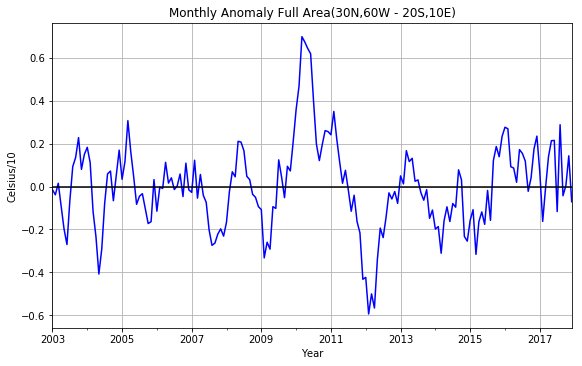

In [13]:
plota_coluna_do_dataframe(funceme_df, 'Monthly Anomaly Full Area(30N,60W - 20S,10E)',COLUNA_ANOMALIA_DO_MES)

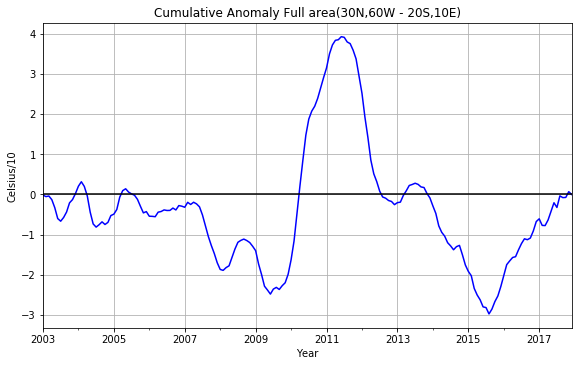

In [14]:
plota_coluna_do_dataframe(funceme_df, 'Cumulative Anomaly Full area(30N,60W - 20S,10E)',COLUNA_ANOMALIA_ACUMULADA)

## ATN/ATS/ATL3

In [15]:
'''ATN : 20N-0N / 50W-20W
ATS : 0N-18W / 30W-0W
DIPOLE = ATN - ATS
faz tambem ATL3
ATL3 : 3N-3S / 20W-0W
'''

'ATN : 20N-0N / 50W-20W\nATS : 0N-18W / 30W-0W\nDIPOLE = ATN - ATS\nfaz tambem ATL3\nATL3 : 3N-3S / 20W-0W\n'

In [16]:

colunas_atn_n = constroi_colunas_latitude_longitude(init_lat=19, end_lat=0,
                                                    init_long=49, end_long=20)
colunas_atn_s = constroi_colunas_latitude_longitude(init_lat=-1, end_lat=-17,
                                                    init_long=29, end_long=0)
ATN_df = pd.DataFrame(funceme_df, index=funceme_df.index, columns=colunas_atn_n)
ATS_df = pd.DataFrame(funceme_df, index=funceme_df.index, columns=colunas_atn_s)

#Drop NAN
ATN_df = ATN_df.dropna(axis=1, how='any')
ATS_df = ATS_df.dropna(axis=1, how='any')

#Média mensal
adiciona_media_mensal(ATN_df)
adiciona_media_mensal(ATS_df)
#Climatologia
calcula_climatologia_para_dataframe(ATN_df)
calcula_climatologia_para_dataframe(ATS_df)

#Anomalia
ATN_df = adiciona_anomalia(ATN_df)
ATS_df = adiciona_anomalia(ATS_df)

#AnomaliaCumulativa
ATN_df = adiciona_anomalia_acumulada(ATN_df)
ATs_df = adiciona_anomalia_acumulada(ATS_df)


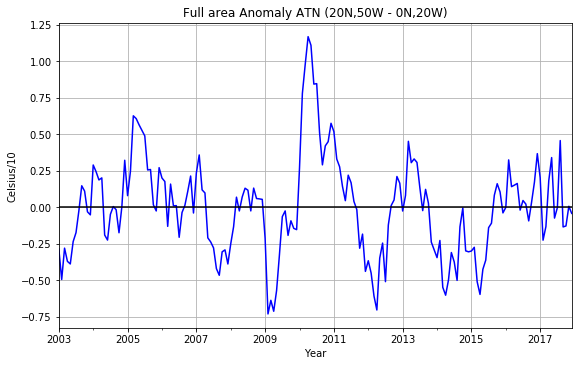

In [17]:
plota_coluna_do_dataframe(ATN_df, 'Full area Anomaly ATN (20N,50W - 0N,20W)',COLUNA_ANOMALIA_DO_MES)

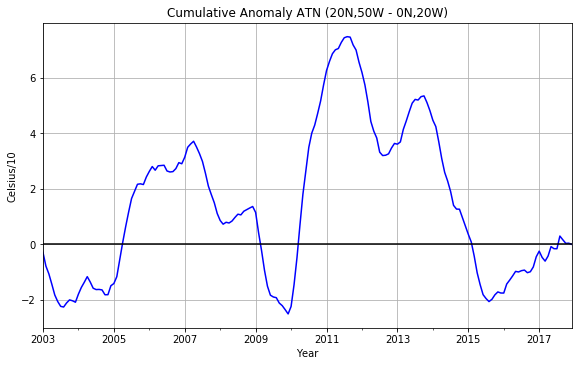

In [18]:
plota_coluna_do_dataframe(ATN_df, 'Cumulative Anomaly ATN (20N,50W - 0N,20W)',COLUNA_ANOMALIA_ACUMULADA)

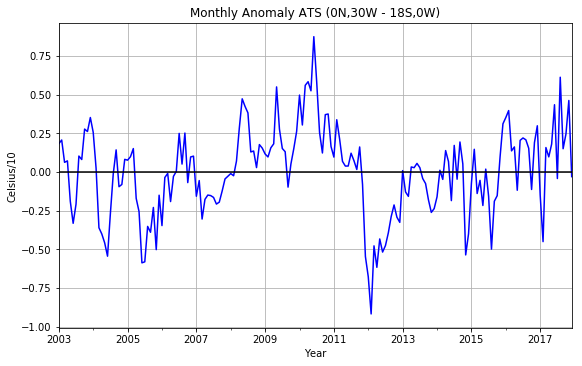

In [19]:
plota_coluna_do_dataframe(ATS_df, 'Monthly Anomaly ATS (0N,30W - 18S,0W)',COLUNA_ANOMALIA_DO_MES)

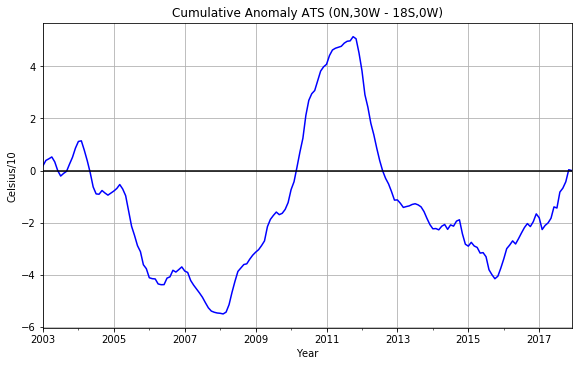

In [20]:
plota_coluna_do_dataframe(ATS_df, 'Cumulative Anomaly ATS (0N,30W - 18S,0W)',COLUNA_ANOMALIA_ACUMULADA)

## Dipole ATN-ATS

In [21]:
dipolo_df = pd.DataFrame(index=funceme_df.index, columns=[COLUNA_ANOMALIA_ACUMULADA])

In [22]:
dipolo_df[COLUNA_ANOMALIA_ACUMULADA] = ATN_df[COLUNA_ANOMALIA_ACUMULADA] - ATS_df[COLUNA_ANOMALIA_ACUMULADA]

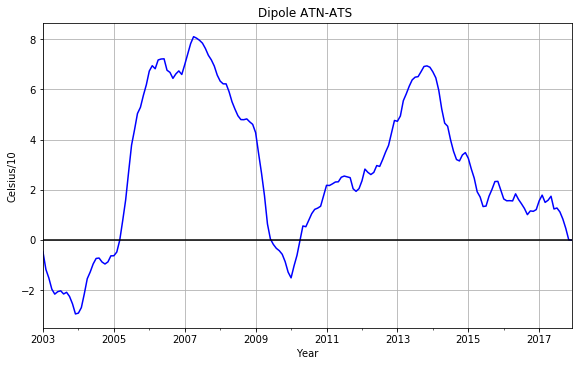

In [23]:
plota_coluna_do_dataframe(dipolo_df, 'Dipole ATN-ATS ',COLUNA_ANOMALIA_ACUMULADA)

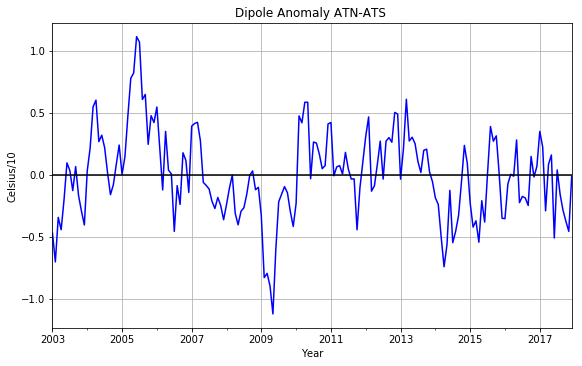

In [24]:
dipolo_df[COLUNA_ANOMALIA_DO_MES] = ATN_df[COLUNA_ANOMALIA_DO_MES] - ATS_df[COLUNA_ANOMALIA_DO_MES]
plota_coluna_do_dataframe(dipolo_df, 'Dipole Anomaly ATN-ATS ',COLUNA_ANOMALIA_DO_MES)

# ATL3(3N-3S / 20W-0W)

In [25]:
# ATL3 : 3N-3S / 20W-0W

colunas_atl3 = constroi_colunas_latitude_longitude(init_lat=3, end_lat=-3,
                                                    init_long=20, end_long=0)
ATL3_df=pd.DataFrame(funceme_df, index=funceme_df.index, columns=colunas_atl3)
ATL3_df = ATL3_df.dropna(axis=1, how='any')
adiciona_media_mensal(ATL3_df)
calcula_climatologia_para_dataframe(ATL3_df)
ATL3_df = adiciona_anomalia(ATL3_df)
ATL3_df = adiciona_anomalia_acumulada(ATL3_df)


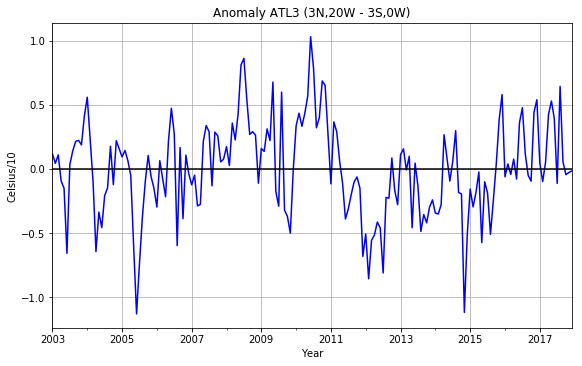

In [26]:
plota_coluna_do_dataframe(ATL3_df, 'Anomaly ATL3 (3N,20W - 3S,0W)',COLUNA_ANOMALIA_DO_MES)

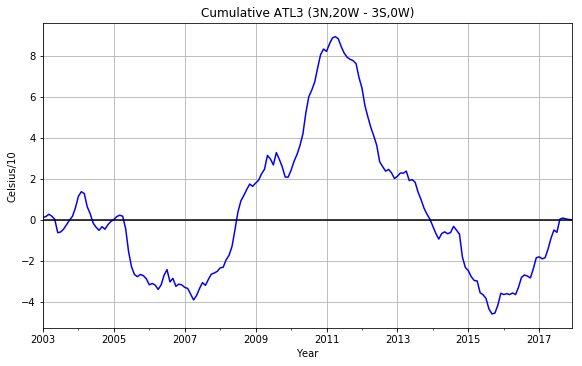

In [27]:
plota_coluna_do_dataframe(ATL3_df, 'Cumulative ATL3 (3N,20W - 3S,0W)',COLUNA_ANOMALIA_ACUMULADA)

# Same analysis fom jan/2003 to dez/2017

## TN (27N,59W - 5N,15E)

In [28]:
# Construir colunas
colunas_tn = constroi_colunas_latitude_longitude(init_lat=27, end_lat=3,
                                                    init_long=59, end_long=17)

#Montar dataframe
tn_df=pd.DataFrame(geral_df, index=geral_df.index, columns=colunas_tn)

#Filtrar por data
tn_df = tn_df.loc['2003-01-01':'2017-12-01']

#Remover NAN
tn_df = tn_df.replace(9999.8, np.nan)
tn_df = tn_df.dropna(axis=1, how='any')

#Calcula media mensal
adiciona_media_mensal(tn_df)

#Calcular climatologia
# calcula_climatologia_para_dataframe(tn_df)

#Calcular anomalia mensal
tn_df = adiciona_anomalia(tn_df)

#Montar anomalia acumulada
tn_df = adiciona_anomalia_acumulada(tn_df)


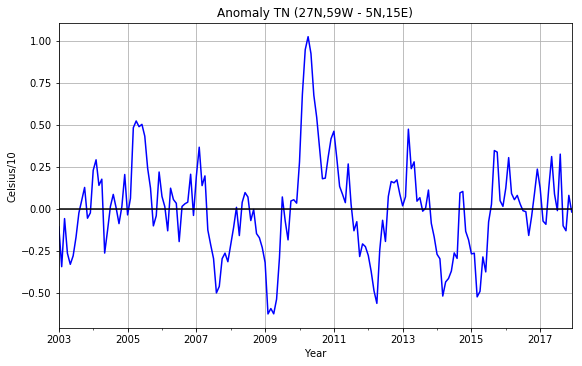

In [29]:
plota_coluna_do_dataframe(tn_df, 'Anomaly TN (27N,59W - 5N,15E)',COLUNA_ANOMALIA_DO_MES)

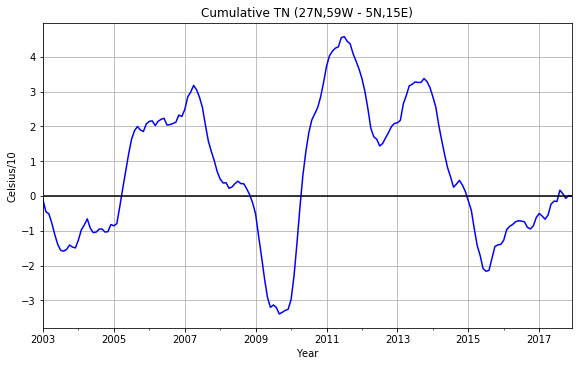

In [30]:
plota_coluna_do_dataframe(tn_df, 'Cumulative TN (27N,59W - 5N,15E)',COLUNA_ANOMALIA_ACUMULADA)

## TS (5N,59W - 20S,15E)

In [31]:
# Construir colunas
colunas_ts = constroi_colunas_latitude_longitude(init_lat=5, end_lat=-20,
                                                    init_long=59, end_long=-17)

#Montar dataframe
ts_df=pd.DataFrame(geral_df, index=geral_df.index, columns=colunas_ts)

#Filtrar por data
ts_df = ts_df.loc['2003-01-01':'2017-12-01']

#Remover NAN
ts_df = ts_df.replace(9999.8, np.nan)
ts_df = ts_df.dropna(axis=1, how='any')

#Calcula media mensal
adiciona_media_mensal(ts_df)

#Calcular climatologia
# calcula_climatologia_para_dataframe(ts_df)

#Calcular anomalia mensal
ts_df = adiciona_anomalia(ts_df)

#Montar anomalia acumulada
ts_df = adiciona_anomalia_acumulada(ts_df)



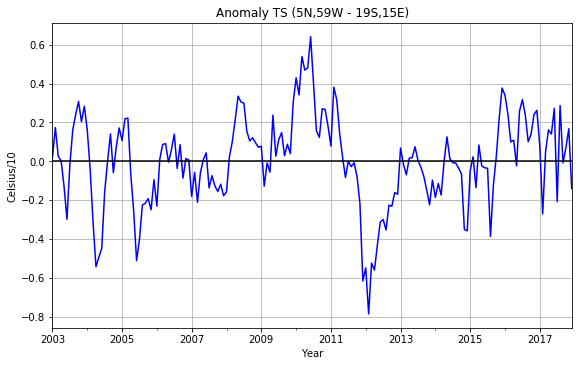

In [32]:
plota_coluna_do_dataframe(ts_df, 'Anomaly TS (5N,59W - 19S,15E)',COLUNA_ANOMALIA_DO_MES)

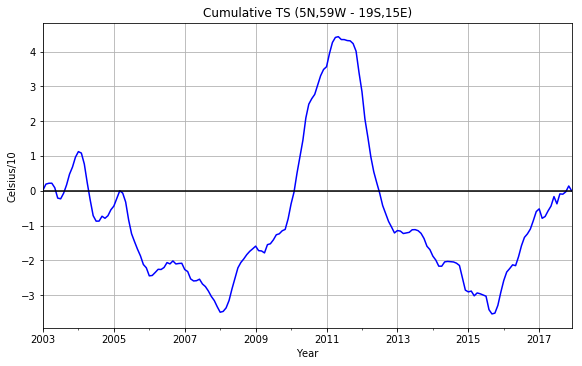

In [33]:
plota_coluna_do_dataframe(ts_df, 'Cumulative TS (5N,59W - 19S,15E)',COLUNA_ANOMALIA_ACUMULADA)

## Dipole TN-TS

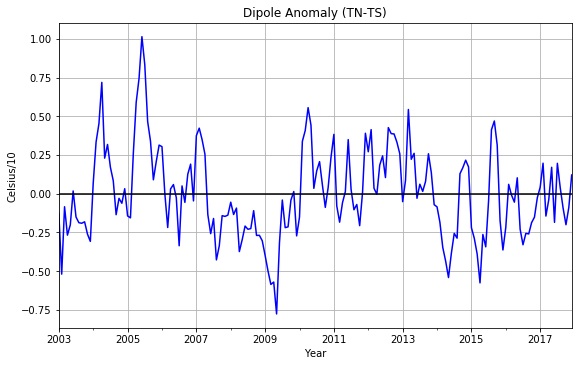

In [34]:
dipolo_df = pd.DataFrame(index=ts_df.index, columns=[COLUNA_ANOMALIA_DO_MES])
dipolo_df[COLUNA_ANOMALIA_DO_MES] = tn_df[COLUNA_ANOMALIA_DO_MES] - ts_df[COLUNA_ANOMALIA_DO_MES]
plota_coluna_do_dataframe(dipolo_df, 'Dipole Anomaly (TN-TS)',COLUNA_ANOMALIA_DO_MES)

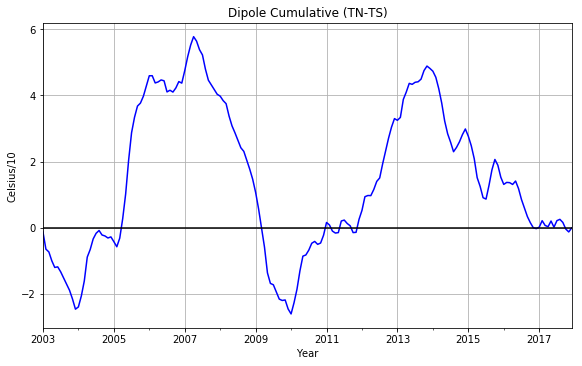

In [35]:
ipolo_df = pd.DataFrame(index=ts_df.index, columns=[COLUNA_ANOMALIA_ACUMULADA])
dipolo_df[COLUNA_ANOMALIA_ACUMULADA] = tn_df[COLUNA_ANOMALIA_ACUMULADA] - ts_df[COLUNA_ANOMALIA_ACUMULADA]
plota_coluna_do_dataframe(dipolo_df, 'Dipole Cumulative (TN-TS)',COLUNA_ANOMALIA_ACUMULADA)